In [1]:
!pip install --upgrade pip
!pip install -q efficientnet

In [7]:
import numpy as np 
import pandas as pd

import time
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet101, ResNet101V2, VGG16, VGG19, ResNet50, ResNet50V2, ResNet152, ResNet152V2, InceptionResNetV2, Xception, InceptionV3
from efficientnet.tfkeras import EfficientNetB7, EfficientNetL2

from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
print(tf.__version__)

2.4.1


In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


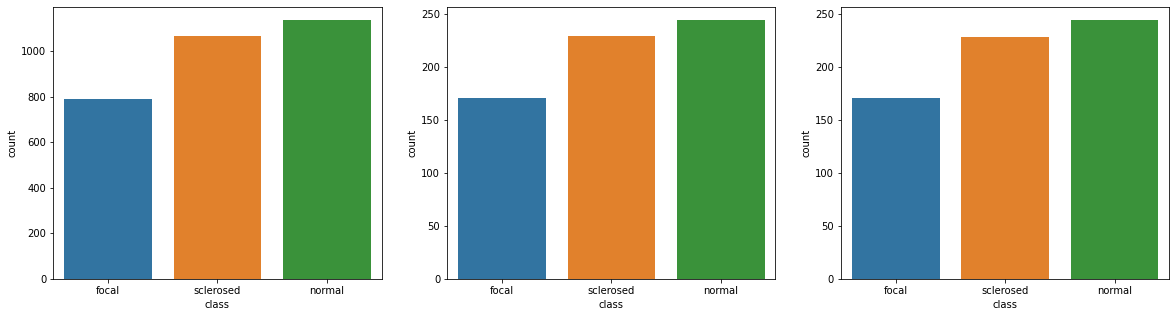

In [10]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [11]:
BUFFER_SIZE = len(train_folders)
BATCH_SIZE = 32
IMG_SIZE = 150
EPOCH = 60

In [12]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [13]:
train_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_folders,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=BUFFER_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMG_SIZE, IMG_SIZE))

validation_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                              shuffle=BUFFER_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              class_mode='categorical', 
                                                              target_size=(IMG_SIZE, IMG_SIZE))

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.


In [14]:
test_datagen = ImageDataGenerator( rescale = 1.0/IMG_SIZE)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
test_generator = test_datagen.flow_from_directory(test_folders,
                                                   batch_size=BATCH_SIZE,
                                                   shuffle=BUFFER_SIZE,
                                                   class_mode='categorical',
                                                   target_size=(IMG_SIZE, IMG_SIZE))

Found 643 images belonging to 3 classes.


In [15]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'focal': 0, 'normal': 1, 'sclerosed': 2}
{0: 'focal', 1: 'normal', 2: 'sclerosed'}


In [16]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


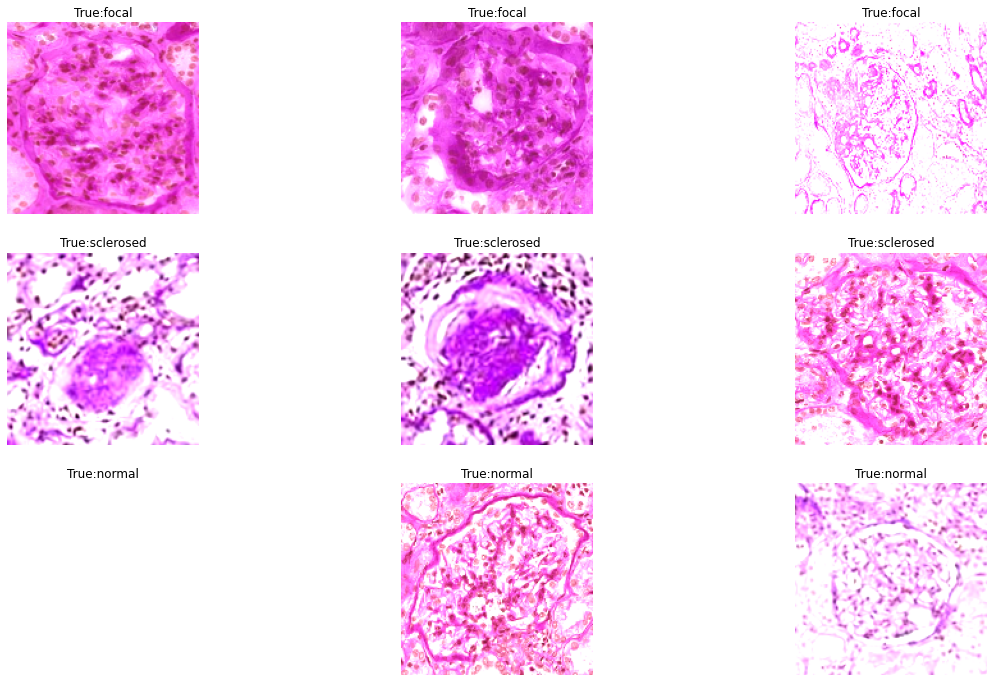

In [17]:
show_few_images(3,None)

## VGG16

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


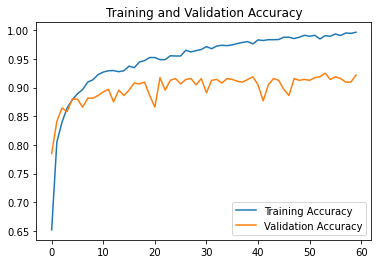

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


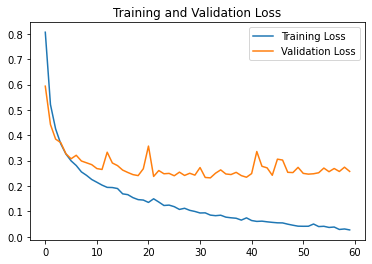

<Figure size 432x288 with 0 Axes>

In [18]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(3, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

vgg16_final_model.summary()
since = time.time()
vgg16_history = vgg16_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=vgg_early_stopping,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg16_history, 'vgg16_model')

In [19]:
vgg16_final_model.evaluate(test_generator)
vgg16_best_model = vgg16_final_model

21/21 [==============================] - 17s 794ms/step - loss: 0.3493 - acc: 0.8942


## VGG19

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


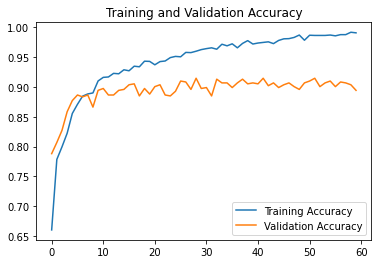

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


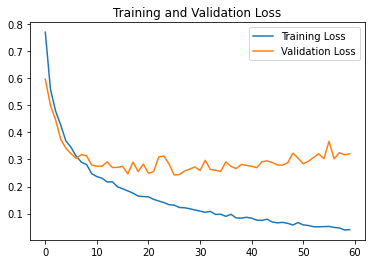

<Figure size 432x288 with 0 Axes>

In [20]:
vgg19_model = VGG19(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
for layers in vgg19_model.layers:
            layers.trainable=False
last_output = vgg19_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(3, activation = 'softmax')(vgg_x)
vgg19_final_model = Model(vgg19_model.input, vgg_x)
vgg19_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

vgg19_final_model.summary()
since = time.time()
vgg19_history = vgg19_final_model.fit(train_generator, epochs = EPOCH ,validation_data = validation_generator,callbacks=vgg_early_stopping,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg19_history, 'vgg19_model')

In [21]:
vgg19_final_model.evaluate(test_generator)
vgg19_best_model = vgg19_final_model

21/21 [==============================] - 20s 966ms/step - loss: 0.3174 - acc: 0.9005


## ResNet50

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

94/94 [==============================] - 629s 7s/step - loss: 1.1480 - acc: 0.7582 - val_loss: 1.6714 - val_acc: 0.2648
Epoch 2/60
94/94 [==============================] - 610s 7s/step - loss: 0.1046 - acc: 0.9631 - val_loss: 1.9036 - val_acc: 0.2508
Epoch 3/60
94/94 [==============================] - 620s 7s/step - loss: 0.0489 - acc: 0.9855 - val_loss: 1.8260 - val_acc: 0.3723
Epoch 4/60
94/94 [==============================] - 616s 7s/step - loss: 0.0236 - acc: 0.9929 - val_loss: 4.3645 - val_acc: 0.2648
Epoch 5/60
94/94 [==============================] - 620s 7s/step - loss: 0.0183 - acc: 0.9930 - val_loss: 2.4939 - val_acc: 0.2648
Epoch 6/60
94/94 [==============================] - 618s 7s/step - loss: 0.0133 - acc: 0.9963 - val_loss: 2.3502 - val_acc: 0.2617
Epoch 7/60
94/94 [==============================] - 622s 7s/step - loss: 0.0176 - acc: 0.9954 - val_loss: 1.7697 - val_acc: 0.3816
Epoch 8/60
94/94 [==============================] - 614s 7s/step - loss: 0.0052 - acc: 0.9979 

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


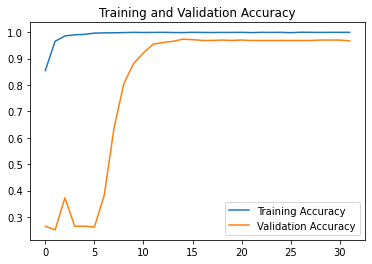

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


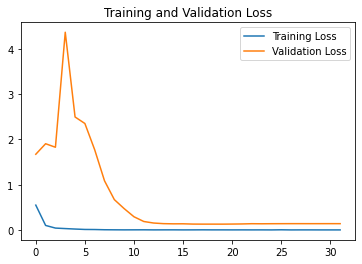

<Figure size 432x288 with 0 Axes>

In [22]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(3,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_early_stopping,reduce_lr]

resnet50_x_final_model.summary()
since = time.time()
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet50_history, 'resnet50_model')

In [23]:
resnet50_x_final_model.evaluate(test_generator)
resnet50_best_model = resnet50_x_final_model

21/21 [==============================] - 15s 716ms/step - loss: 0.1332 - acc: 0.9720


## ResNet50V2

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/60
94/94 [==============================] - 501s 5s/step - loss: 0.8994 - acc: 0.7319 - val_loss: 0.9061 - val_acc: 0.7508
Epoch 2/60
94/94 [==============================] - 499s 5s/step - loss: 0.1753 - acc: 0.9310 - val_loss: 0.3086 - val_acc: 0.8660
Epoch 3/60
94/94 [==============================] - 498s 5s/step - loss: 0.0626 - acc: 0.9779 - val_loss: 0.2264 - val_acc: 0.9237
Epoch 4/60
94/94 [==============================] - 498s 5s/step - loss: 0.0458 - acc: 0.9849 - val_loss: 0.2340 - val_acc: 0.9268
Epoch 5/60
94/94 [==============================] - 482s 5s/step - loss: 0.0358 - acc: 0.9876 - val_loss: 0.1415 - val_acc: 0.9517
Epoch 6/60
94/94 [==============================] - 495s 5s/step - loss: 0.0401 - acc: 0.9872 - val_loss: 0.4085 - val_acc: 0.8551
Epoch 7/60
94/94 [==============================] - 485s 5s/step - loss: 0.0271 - acc: 0.9906 - val_loss: 0.2991 - val_acc: 0.9003
Epoch 8/60
94/94 [==============================] - 492s 5s/step - loss: 0.0168 - a

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


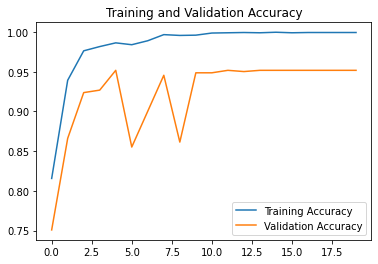

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


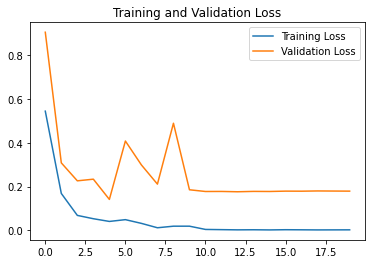

<Figure size 432x288 with 0 Axes>

In [24]:
ResNet50v2_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

for layers in ResNet50v2_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50v2_x = Flatten()(ResNet50v2_model.output)
resnet50v2_x = Dense(256,activation='relu')(resnet50v2_x)
resnet50v2_x = Dense(3,activation='softmax')(resnet50v2_x)
resnet50v2_x_final_model = Model(inputs=ResNet50v2_model.input, outputs=resnet50v2_x)
resnet50v2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_early_stopping,reduce_lr]

resnet50v2_x_final_model.summary()
since = time.time()
resnet50v2_history = resnet50v2_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet50v2_history, 'resnet50v2_model')

In [25]:
resnet50v2_x_final_model.evaluate(test_generator)
resnet50v2_best_model = resnet50v2_x_final_model

21/21 [==============================] - 12s 578ms/step - loss: 0.1366 - acc: 0.9673


## ResNet101

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/60
94/94 [==============================] - 823s 9s/step - loss: 2.2366 - acc: 0.5990 - val_loss: 1.1059 - val_acc: 0.3333
Epoch 2/60
94/94 [==============================] - 803s 9s/step - loss: 0.3411 - acc: 0.8519 - val_loss: 1.6335 - val_acc: 0.3551
Epoch 3/60
94/94 [==============================] - 807s 9s/step - loss: 0.2413 - acc: 0.8986 - val_loss: 2.9626 - val_acc: 0.3551
Epoch 4/60
94/94 [==============================] - 794s 8s/step - loss: 0.1731 - acc: 0.9334 - val_loss: 1.5709 - val_acc: 0.2648
Epoch 5/60
94/94 [==============================] - 813s 9s/step - loss: 0.1573 - acc: 0.9348 - val_loss: 1.2179 - val_acc: 0.2601
Epoch 6/60
94/94 [==============================] - 795s 8s/step - loss: 0.1105 - acc: 0.9622 - val_loss: 1.3719 - val_acc: 0.2664
Epoch 7/60
94/94 [==============================] - 800s 9s/step - loss: 0.0956 - acc: 0.9632 - val_loss: 1.1716 - val_acc: 0.3255
Epoch 8/60
94/94 [==============================] - 794s 8s/step - loss: 0.0572 - a

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


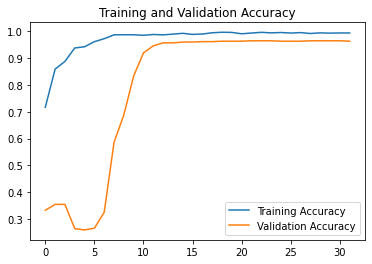

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


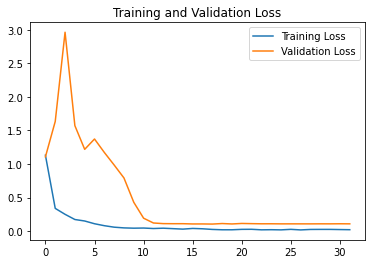

<Figure size 432x288 with 0 Axes>

In [26]:
ResNet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

for layers in ResNet101_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet101_x = Flatten()(ResNet101_model.output)
resnet101_x = Dense(256,activation='relu')(resnet101_x)
resnet101_x = Dense(3,activation='softmax')(resnet101_x)
resnet101_x_final_model = Model(inputs=ResNet101_model.input, outputs=resnet101_x)
resnet101_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_early_stopping,reduce_lr]

resnet101_x_final_model.summary()
since = time.time()
resnet101_history = resnet101_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet101_history, 'resnet101_model')

In [27]:
resnet101_x_final_model.evaluate(test_generator)
resnet101_best_model = resnet101_x_final_model

21/21 [==============================] - 21s 997ms/step - loss: 0.1452 - acc: 0.9518


## ResNet101V2

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/60
94/94 [==============================] - 701s 7s/step - loss: 0.9413 - acc: 0.7260 - val_loss: 5.5913 - val_acc: 0.3801
Epoch 2/60
94/94 [==============================] - 698s 7s/step - loss: 0.1739 - acc: 0.9351 - val_loss: 0.5094 - val_acc: 0.8255
Epoch 3/60
94/94 [==============================] - 693s 7s/step - loss: 0.1050 - acc: 0.9610 - val_loss: 0.5008 - val_acc: 0.8255
Epoch 4/60
94/94 [==============================] - 696s 7s/step - loss: 0.0789 - acc: 0.9704 - val_loss: 0.2786 - val_acc: 0.9050
Epoch 5/60
94/94 [==============================] - 693s 7s/step - loss: 0.0459 - acc: 0.9856 - val_loss: 0.1221 - val_acc: 0.9579
Epoch 6/60
94/94 [==============================] - 695s 7s/step - loss: 0.0152 - acc: 0.9963 - val_loss: 0.2660 - val_acc: 0.9252
Epoch 7/60
94/94 [==============================] - 701s 7s/step - loss: 0.0196 - acc: 0.9942 - val_loss: 0.2586 - val_acc: 0.9268
Epoch 8/60
94/94 [==============================] - 696s 7s/step - loss: 0.0156 - a

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


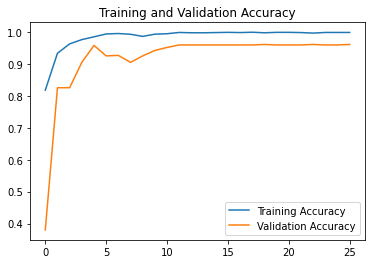

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


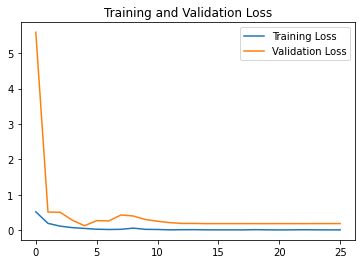

<Figure size 432x288 with 0 Axes>

In [28]:
ResNet101v2_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

for layers in ResNet101v2_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet101v2_x = Flatten()(ResNet101v2_model.output)
resnet101v2_x = Dense(256,activation='relu')(resnet101v2_x)
resnet101v2_x = Dense(3,activation='softmax')(resnet101v2_x)
resnet101v2_x_final_model = Model(inputs=ResNet101v2_model.input, outputs=resnet101v2_x)
resnet101v2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet101v2_x_final_model.summary()
since = time.time()
resnet101v2_history = resnet101v2_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet101v2_history, 'resnet101v2_model')

In [29]:
resnet101v2_x_final_model.evaluate(test_generator)
resnet101v2_best_model = resnet101v2_x_final_model

21/21 [==============================] - 19s 890ms/step - loss: 0.1247 - acc: 0.9627


## ResNet152

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Total params: 71,479,171
Trainable params: 71,327,747
Non-trainable params: 151,424
__________________________________________________________________________________________________
Epoch 1/60
94/94 [==============================] - 1066s 11s/step - loss: 1.2659 - acc: 0.7364 - val_loss: 2.7080 - val_acc: 0.2648
Epoch 2/60
94/94 [==============================] - 1056s 11s/step - loss: 0.1767 - acc: 0.9371 - val_loss: 1.3182 - val_acc: 0.2648
Epoch 3/60
94/94 [==============================] - 1047s 11s/step - loss: 0.1046 - acc: 0.9645 - val_loss: 3.0926 - val_acc: 0.2648
Epoch 4/60
94/94 [==============================] - 1055s 11s/step - loss: 0.0464 - acc: 0.9811 - val_loss: 1.2981 - val_acc: 0.2632
Epoch 5/60
94/94 [==============================] - 1054s 11s/step - loss: 0.0231 - acc: 0.9926 - val_loss: 1.5836 - val_acc: 0.3847
Epoch 6/60
94/94 [==============================] - 1051s 11s/step - loss: 0.0233 - acc: 0.9888 - val_loss: 2.7258 - val_acc: 0.2321
Epoch 7/60
94/94 [=

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


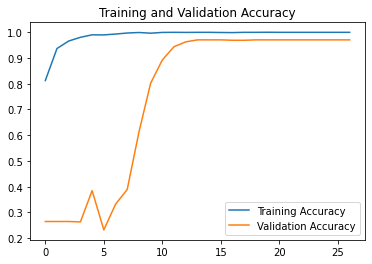

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


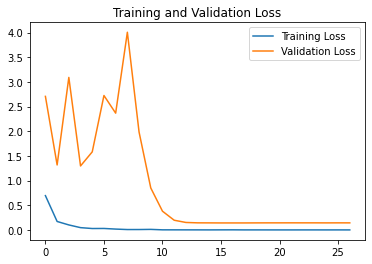

<Figure size 432x288 with 0 Axes>

In [30]:
ResNet152_model = ResNet152(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

for layers in ResNet152_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
resnet152_x = Flatten()(ResNet152_model.output)
resnet152_x = Dense(256,activation='relu')(resnet152_x)
resnet152_x = Dense(3,activation='softmax')(resnet152_x)
resnet152_x_final_model = Model(inputs=ResNet152_model.input, outputs=resnet152_x)
resnet152_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet152_x_final_model.summary()
since = time.time()
resnet152_history = resnet152_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet152_history, 'resnet152_model')

In [31]:
resnet152_x_final_model.evaluate(test_generator)
resnet152_best_model = resnet152_x_final_model

21/21 [==============================] - 28s 1s/step - loss: 0.1394 - acc: 0.9720


## ResNet152V2

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

Epoch 1/60
94/94 [==============================] - 1035s 11s/step - loss: 1.1990 - acc: 0.6276 - val_loss: 1.1422 - val_acc: 0.7804
Epoch 2/60
94/94 [==============================] - 1009s 11s/step - loss: 0.3291 - acc: 0.9033 - val_loss: 0.6248 - val_acc: 0.7991
Epoch 3/60
94/94 [==============================] - 993s 11s/step - loss: 0.1778 - acc: 0.9276 - val_loss: 0.2612 - val_acc: 0.9050
Epoch 4/60
94/94 [==============================] - 997s 11s/step - loss: 0.1185 - acc: 0.9604 - val_loss: 0.1666 - val_acc: 0.9455
Epoch 5/60
94/94 [==============================] - 997s 11s/step - loss: 0.0552 - acc: 0.9825 - val_loss: 0.2449 - val_acc: 0.9190
Epoch 6/60
94/94 [==============================] - 1001s 11s/step - loss: 0.0778 - acc: 0.9764 - val_loss: 0.4621 - val_acc: 0.8598
Epoch 7/60
94/94 [==============================] - 1004s 11s/step - loss: 0.0456 - acc: 0.9850 - val_loss: 0.2331 - val_acc: 0.9361
Epoch 8/60
94/94 [==============================] - 992s 11s/step - loss

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


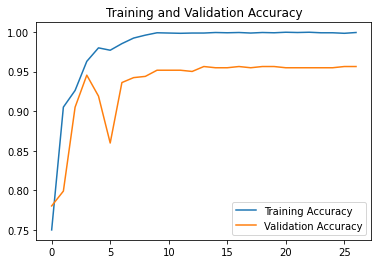

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


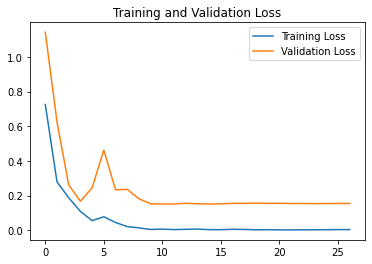

<Figure size 432x288 with 0 Axes>

In [32]:
ResNet152v2_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=3)

for layers in ResNet152v2_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
resnet152v2_x = Flatten()(ResNet152v2_model.output)
resnet152v2_x = Dense(256,activation='relu')(resnet152v2_x)
resnet152v2_x = Dense(3,activation='softmax')(resnet152v2_x)
resnet152v2_x_final_model = Model(inputs=ResNet152v2_model.input, outputs=resnet152v2_x)
resnet152v2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

resnet152v2_x_final_model.summary()
since = time.time()
resnet152v2_history = resnet152v2_x_final_model.fit(train_generator, epochs = EPOCH, validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet152v2_history, 'resnet152v2_model')

In [33]:
resnet152v2_x_final_model.evaluate(test_generator)
resnet152v2_best_model = resnet152v2_x_final_model

21/21 [==============================] - 27s 1s/step - loss: 0.1493 - acc: 0.9611


## EfficientNetB7

last layer output shape:  (None, 2560)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 64)   1728        input_9[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 64)   0           stem_bn[0][0]                    
_____________________________________________________

__________________________________________________________________________________________________
block6d_activation (Activation) (None, 5, 5, 2304)   0           block6d_bn[0][0]                 
__________________________________________________________________________________________________
block6d_se_squeeze (GlobalAvera (None, 2304)         0           block6d_activation[0][0]         
__________________________________________________________________________________________________
block6d_se_reshape (Reshape)    (None, 1, 1, 2304)   0           block6d_se_squeeze[0][0]         
__________________________________________________________________________________________________
block6d_se_reduce (Conv2D)      (None, 1, 1, 96)     221280      block6d_se_reshape[0][0]         
__________________________________________________________________________________________________
block6d_se_expand (Conv2D)      (None, 1, 1, 2304)   223488      block6d_se_reduce[0][0]          
__________

Epoch 1/60
94/94 [==============================] - 497s 5s/step - loss: 1.0548 - acc: 0.5517 - val_loss: 0.5106 - val_acc: 0.8115
Epoch 2/60
94/94 [==============================] - 469s 5s/step - loss: 0.6788 - acc: 0.6979 - val_loss: 0.4680 - val_acc: 0.7913
Epoch 3/60
94/94 [==============================] - 467s 5s/step - loss: 0.5938 - acc: 0.7441 - val_loss: 0.4070 - val_acc: 0.8333
Epoch 4/60
94/94 [==============================] - 471s 5s/step - loss: 0.5469 - acc: 0.7664 - val_loss: 0.3757 - val_acc: 0.8396
Epoch 5/60
94/94 [==============================] - 472s 5s/step - loss: 0.5205 - acc: 0.7737 - val_loss: 0.3490 - val_acc: 0.8769
Epoch 6/60
94/94 [==============================] - 474s 5s/step - loss: 0.4964 - acc: 0.7891 - val_loss: 0.4334 - val_acc: 0.8100

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/60
94/94 [==============================] - 470s 5s/step - loss: 0.4750 - acc: 0.8020 - val_loss: 0.3165 - val_acc: 0.8536
Ep

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


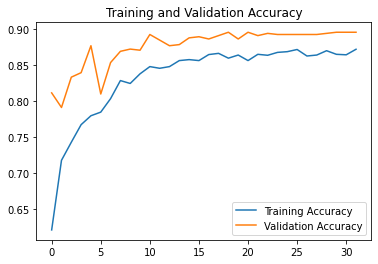

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


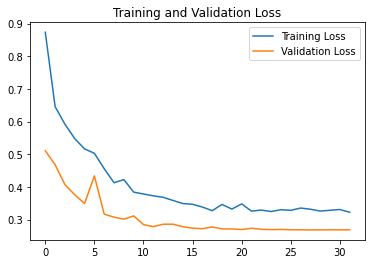

<Figure size 432x288 with 0 Axes>

In [34]:
effb7_model = EfficientNetB7(pooling='avg', 
                    weights='imagenet', 
                    include_top=False, 
                    input_shape=(150,150,3))
for layers in effb7_model.layers:
            layers.trainable=False

last_layer = effb7_model.get_layer('avg_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
effb7_x = Flatten()(last_output)
effb7_x = Dense(1024, activation = 'relu')(effb7_x)
effb7_x = Dropout(0.2)(effb7_x)
effb7_x = Dense(3, activation = 'softmax')(effb7_x)
effb7_final_model = Model(effb7_model.input, effb7_x)
effb7_final_model.compile(loss = 'categorical_crossentropy',
                          optimizer= 'adam', 
                          metrics=['acc'])

# EFFB7
effb7_final_model.summary()

reduce_lr = ReduceLROnPlateau(factor=0.5, patience=1, verbose=1, mode='min', epsilon=0.0001, min_lr=0)
es = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min', restore_best_weights=True)
callbacks_list = [reduce_lr, es]

since = time.time()
effb7_history = effb7_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effb7_history, 'effb7_model')

In [35]:
effb7_final_model.evaluate(test_generator)
effb7_best_model = effb7_final_model

21/21 [==============================] - 79s 4s/step - loss: 0.2920 - acc: 0.8942


## EfficientNetL2

last layer output shape:  (None, 5504)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 136)  3672        input_10[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 136)  544         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 136)  0           stem_bn[0][0]                    
_____________________________________________________

block4g_bn (BatchNormalization) (None, 10, 10, 2064) 8256        block4g_dwconv[0][0]             
__________________________________________________________________________________________________
block4g_activation (Activation) (None, 10, 10, 2064) 0           block4g_bn[0][0]                 
__________________________________________________________________________________________________
block4g_se_squeeze (GlobalAvera (None, 2064)         0           block4g_activation[0][0]         
__________________________________________________________________________________________________
block4g_se_reshape (Reshape)    (None, 1, 1, 2064)   0           block4g_se_squeeze[0][0]         
__________________________________________________________________________________________________
block4g_se_reduce (Conv2D)      (None, 1, 1, 86)     177590      block4g_se_reshape[0][0]         
__________________________________________________________________________________________________
block4g_se

                                                                 block6v_se_expand[0][0]          
__________________________________________________________________________________________________
block6v_project_conv (Conv2D)   (None, 5, 5, 824)    4073856     block6v_se_excite[0][0]          
__________________________________________________________________________________________________
block6v_project_bn (BatchNormal (None, 5, 5, 824)    3296        block6v_project_conv[0][0]       
__________________________________________________________________________________________________
block6v_add (Add)               (None, 5, 5, 824)    0           block6v_project_bn[0][0]         
                                                                 block6u_add[0][0]                
__________________________________________________________________________________________________
block7a_expand_conv (Conv2D)    (None, 5, 5, 4944)   4073856     block6v_add[0][0]                
__________

94/94 [==============================] - 1711s 18s/step - loss: 9.1922 - acc: 0.3483 - val_loss: 1.0853 - val_acc: 0.3801
Epoch 2/60
94/94 [==============================] - 1672s 18s/step - loss: 1.0940 - acc: 0.3716 - val_loss: 1.0956 - val_acc: 0.3801

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 3/60
94/94 [==============================] - 1674s 18s/step - loss: 1.0950 - acc: 0.3795 - val_loss: 1.0940 - val_acc: 0.3801

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/60
94/94 [==============================] - 1679s 18s/step - loss: 1.0934 - acc: 0.3807 - val_loss: 1.0932 - val_acc: 0.3801

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 5/60
94/94 [==============================] - 1678s 18s/step - loss: 1.0936 - acc: 0.3680 - val_loss: 1.0928 - val_acc: 0.3801

Epoch 00005: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Elapsed Time in 8416 se

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


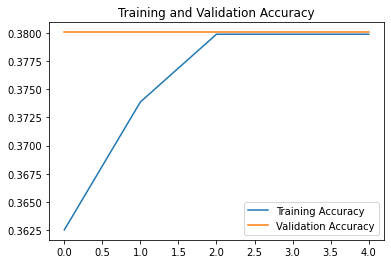

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


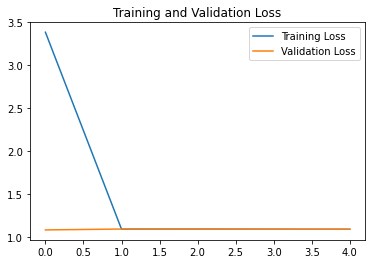

<Figure size 432x288 with 0 Axes>

In [36]:
path_weight = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/efficientnet/noisy-student/notop/efficientnet-l2_noisy-student_notop.h5'
effl2_model = EfficientNetL2(pooling='avg', 
                             weights=path_weight, 
                             include_top=False, 
                             input_shape=(IMG_SIZE,IMG_SIZE,3),
                             drop_connect_rate=0)
for layers in effl2_model.layers:
            layers.trainable=False

last_layer = effl2_model.get_layer('avg_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
effl2_x = Flatten()(last_output)
effl2_x = Dense(1024, activation = 'relu')(effl2_x)
effl2_x = Dropout(0.2)(effl2_x)
effl2_x = Dense(3, activation = 'softmax')(effl2_x)
effl2_final_model = Model(effl2_model.input, effl2_x)
effl2_final_model.compile(loss = 'categorical_crossentropy',
                          optimizer= 'adam', 
                          metrics=['acc'])

# EFFL2
effl2_final_model.summary()

since = time.time()
effl2_history = effl2_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effl2_history, 'effl2_model')

In [37]:
effl2_final_model.evaluate(test_generator)
effl2_best_model = effl2_final_model

21/21 [==============================] - 296s 14s/step - loss: 1.0856 - acc: 0.3795


## InceptionV3

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

Epoch 1/60
94/94 [==============================] - 50s 496ms/step - loss: 1.8198 - acc: 0.6299 - val_loss: 0.3633 - val_acc: 0.8380
Epoch 2/60
94/94 [==============================] - 45s 476ms/step - loss: 0.3281 - acc: 0.8691 - val_loss: 0.3239 - val_acc: 0.8614
Epoch 3/60
94/94 [==============================] - 43s 458ms/step - loss: 0.2388 - acc: 0.9107 - val_loss: 0.2703 - val_acc: 0.8956
Epoch 4/60
94/94 [==============================] - 44s 469ms/step - loss: 0.1944 - acc: 0.9246 - val_loss: 0.2755 - val_acc: 0.8863

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/60
94/94 [==============================] - 43s 459ms/step - loss: 0.1289 - acc: 0.9611 - val_loss: 0.2528 - val_acc: 0.9097
Epoch 6/60
94/94 [==============================] - 43s 458ms/step - loss: 0.0999 - acc: 0.9660 - val_loss: 0.2576 - val_acc: 0.9050

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 7/60
94/94 [======================

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


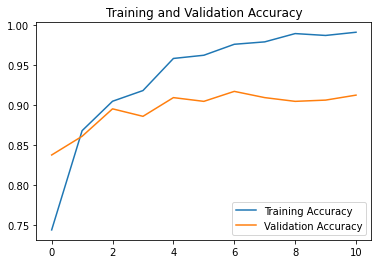

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


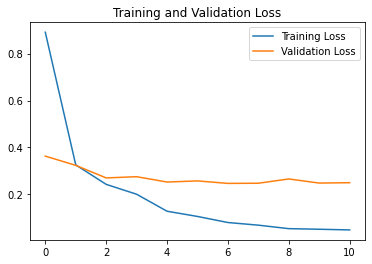

<Figure size 432x288 with 0 Axes>

In [38]:
incepv3_model = InceptionV3(pooling='avg', 
                          weights='imagenet', 
                          include_top=False, 
                          input_shape=(IMG_SIZE,IMG_SIZE,3))
for layers in incepv3_model.layers:
            layers.trainable=False

incepv3_x = incepv3_model.output
incepv3_x = Flatten()(incepv3_x)
incepv3_x = Dense(1024, activation='relu')(incepv3_x)
incepv3_x = Dropout(0.2)(incepv3_x)
incepv3_x = Dense(3, activation='softmax')(incepv3_x)
incepv3_final_model = Model(inputs=incepv3_model.input, outputs=incepv3_x)
incepv3_final_model.compile(loss = 'categorical_crossentropy',
                          optimizer= 'adam', 
                          metrics=['acc'])

incepv3_final_model.summary()

since = time.time()
incepv3_history = incepv3_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(incepv3_history, 'incepv3_model')

In [39]:
incepv3_final_model.evaluate(test_generator)
incepv3_best_model = incepv3_final_model

21/21 [==============================] - 8s 370ms/step - loss: 0.2413 - acc: 0.9036


## InceptionResNetV2

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
___________________________________________________________________________________________

Epoch 1/60
94/94 [==============================] - 140s 1s/step - loss: 2.3853 - acc: 0.5737 - val_loss: 0.4309 - val_acc: 0.8536
Epoch 2/60
94/94 [==============================] - 123s 1s/step - loss: 0.4512 - acc: 0.8339 - val_loss: 0.4545 - val_acc: 0.8240

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 3/60
94/94 [==============================] - 122s 1s/step - loss: 0.3697 - acc: 0.8486 - val_loss: 0.3982 - val_acc: 0.8380
Epoch 4/60
94/94 [==============================] - 123s 1s/step - loss: 0.3188 - acc: 0.8765 - val_loss: 0.3136 - val_acc: 0.8614
Epoch 5/60
94/94 [==============================] - 121s 1s/step - loss: 0.2735 - acc: 0.8926 - val_loss: 0.3086 - val_acc: 0.8707
Epoch 6/60
94/94 [==============================] - 122s 1s/step - loss: 0.2902 - acc: 0.8747 - val_loss: 0.2642 - val_acc: 0.9019
Epoch 7/60
94/94 [==============================] - 122s 1s/step - loss: 0.2369 - acc: 0.9148 - val_loss: 0.2591 - val_acc: 0.8988
Ep

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


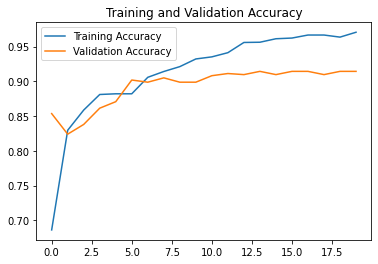

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


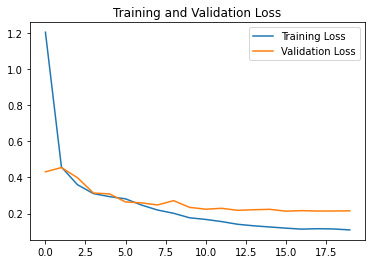

<Figure size 432x288 with 0 Axes>

In [40]:
inresv2_model = InceptionResNetV2(pooling='avg', 
                                  weights='imagenet', 
                                  include_top=False, 
                                  input_shape=(IMG_SIZE,IMG_SIZE,3))
for layers in inresv2_model.layers:
            layers.trainable=False

inresv2_x = inresv2_model.output
inresv2_x = Flatten()(inresv2_x)
inresv2_x = Dense(1024, activation='relu')(inresv2_x)
inresv2_x = Dropout(0.2)(inresv2_x)
inresv2_x = Dense(3, activation='softmax')(inresv2_x)
inresv2_final_model = Model(inputs=inresv2_model.input, outputs=inresv2_x)
inresv2_final_model.compile(loss = 'categorical_crossentropy',
                          optimizer= 'adam', 
                          metrics=['acc'])

inresv2_final_model.summary()

since = time.time()
inresv2_history = inresv2_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(inresv2_history, 'inresv2_model')

In [41]:
inresv2_final_model.evaluate(test_generator)
inresv2_best_model = inresv2_final_model

21/21 [==============================] - 23s 1s/step - loss: 0.2539 - acc: 0.9098


## Xception

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_13[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

94/94 [==============================] - 72s 747ms/step - loss: 0.9961 - acc: 0.6686 - val_loss: 0.3357 - val_acc: 0.8629
Epoch 2/60
94/94 [==============================] - 67s 715ms/step - loss: 0.3052 - acc: 0.8812 - val_loss: 0.2874 - val_acc: 0.8801
Epoch 3/60
94/94 [==============================] - 68s 721ms/step - loss: 0.2361 - acc: 0.9075 - val_loss: 0.2611 - val_acc: 0.8988
Epoch 4/60
94/94 [==============================] - 67s 712ms/step - loss: 0.1721 - acc: 0.9362 - val_loss: 0.2213 - val_acc: 0.9159
Epoch 5/60
94/94 [==============================] - 67s 719ms/step - loss: 0.1440 - acc: 0.9429 - val_loss: 0.2141 - val_acc: 0.9097
Epoch 6/60
94/94 [==============================] - 68s 718ms/step - loss: 0.1098 - acc: 0.9589 - val_loss: 0.2545 - val_acc: 0.9034

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/60
94/94 [==============================] - 67s 717ms/step - loss: 0.0841 - acc: 0.9691 - val_loss: 0.2022 - val_acc: 0.9174

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


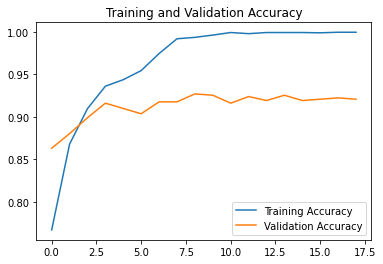

<Figure size 432x288 with 0 Axes>

/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ai1/anaconda3/envs/tf-cpu/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


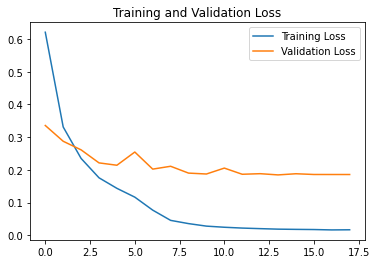

<Figure size 432x288 with 0 Axes>

In [42]:
xcep_model = Xception(pooling='avg', 
                      weights='imagenet', 
                      include_top=False, 
                      input_shape=(IMG_SIZE,IMG_SIZE,3))
for layers in xcep_model.layers:
            layers.trainable=False

xcep_x = xcep_model.output
xcep_x = Flatten()(xcep_x)
xcep_x = Dense(1024, activation='relu')(xcep_x)
xcep_x = Dropout(0.2)(xcep_x)
xcep_x = Dense(3, activation='softmax')(xcep_x)
xcep_final_model = Model(inputs=xcep_model.input, outputs=xcep_x)
xcep_final_model.compile(loss = 'categorical_crossentropy',
                          optimizer= 'adam', 
                          metrics=['acc'])

xcep_final_model.summary()

since = time.time()
xcep_history = xcep_final_model.fit(train_generator,
                                      epochs = EPOCH,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Elapsed Time in {:.0f} second".format(elapsed_time))
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(xcep_history, 'xcep_model')

In [43]:
xcep_final_model.evaluate(test_generator)
xcep_best_model = xcep_final_model

21/21 [==============================] - 12s 571ms/step - loss: 0.2481 - acc: 0.9129
